In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

In [38]:
def LatLonAlt2XYZ(Lat : float,Lon : float,Alt : float) -> tuple:

    a_e = 6378137
    ecc = 0.081819190842622
    ksi = 1.0 / np.sqrt(1 - ecc * ecc * np.sin(Lat) * np.sin(Lat))
    X = (a_e * ksi + Alt) * np.cos(Lat) * np.cos(Lon)
    Y = (a_e * ksi + Alt) * np.cos(Lat) * np.sin(Lon)
    Z = (a_e * ksi * (1 - ecc * ecc) + Alt) * np.sin(Lat)
    return X, Y, Z

In [39]:
def CalcGravity(X:float,Y:float,Z:float)->np.array:
    t2 = X ** 2.0
    t3 = Y ** 2.0
    t4 = Z ** 2.0
    t5 = t2 + t3 + t4
    t6 = 1.0 / t5 ** (3.0 / 2.0)
    t7 = 1.0 / t5 ** (5.0 / 2.0)
    t8 = 1.0 / t5 ** (7.0 / 2.0)
    g = np.array([
       X * 5.3174941173225e-9-X * t6 * 3.9860142624e14-X * t7 * 2.633274580483414e25 + X * t4 * t8 * 1.316637290241707e26,
       Y * 5.3174941173225e-9 - Y * t6 * 3.9860142624e14 - Y * t7 * 2.633274580483414e25 + Y * t4 * t8 * 1.316637290241707e26,
       Z * t6 * -3.9860142624e14 - Z * t7 * 7.899823741450242e25 + Z * t4 * t8 * 1.316637290241707e26])
    return g

In [40]:
def SkewSymmMatr(a : np.array) -> np.array:
    Ax= np.array(
        [[0.0,-a[2],a[1]],
        [a[2],0.0,-a[0]],
        [-a[1],a[0],0.0]])
    return Ax

In [41]:
def cross(a : np.array ,b : np.array) -> np.array:
    axb = SkewSymmMatr(a) @ b
    return axb

In [42]:
def twoPiBound(heading : float) -> float:
    if heading < 0:
        heading = heading + 2.0 * np.pi

    return heading

In [43]:
def Calc_C_N_E(B : float,L : float) -> np.array:

    cosL = np.cos(L)
    sinL = np.sin(L)
    cosB = np.cos(B)
    sinB = np.sin(B)

    C_N_E = np.zeros((3, 3))
    C_N_E[0, 0] = -cosL * sinB
    C_N_E[0, 1] = cosL * cosB
    C_N_E[0, 2] = -sinL
    C_N_E[1, 0] = -sinL * sinB
    C_N_E[1, 1] = sinL * cosB
    C_N_E[1, 2] = cosL
    C_N_E[2, 0] = cosB
    C_N_E[2, 1] = sinB
    C_N_E[2, 2] = 0.0

    return C_N_E

In [44]:
def Calc_F_C_N(B : float,h : float,a_e : float,ecc2 : float) -> np.array:
    sinB = np.sin(B)
    sinB2 = sinB * sinB

    R_N = a_e * (1 - ecc2) / (1 - ecc2 * sinB2) ** 1.5 + h

    R_E = a_e / np.sqrt(1 - ecc2 * sinB2) + h

    F_C_N = np.array([
        [0.0,0.0,1.0 / R_E],
        [0.0,0.0,np.tan(B)/R_E],
        [-1.0/R_N,0.0,0.0]])

    return F_C_N

In [45]:
def DCM_bn(heading : float, pitch : float, roll : float) -> np.array:
    sz = np.sin(pitch)
    cz = np.cos(pitch)
    sy = np.sin(-heading)
    cy = np.cos(-heading)
    sx = np.sin(roll)
    cx = np.cos(roll)

    Cx = np.array([[1, 0, 0],[0, cx, sx],[0, -sx, cx]],dtype = np.float64)
    Cy = np.array([[cy, 0, -sy],[0, 1, 0],[sy, 0, cy]],dtype = np.float64)
    Cz = np.array([[cz, sz, 0],[-sz, cz, 0],[0, 0, 1]],dtype = np.float64)

    Cnb = Cx @ Cz @ Cy

    return Cnb.T

In [46]:
def CalcDCMnue_align(Pos : list,fb : np.array,om_ib : np.array) -> np.array:
    #nue->ned
    fb =np.array([fb[0],fb[2],-fb[1]])
    om_ib = np.array([om_ib[0],om_ib[2],-om_ib[1]])

    om_ie = 7.292115e-5

    cosB = np.cos(Pos[0])
    sinB = np.sin(Pos[0])
    cosL = np.cos(Pos[1])
    sinL = np.sin(Pos[1])

    Lat = Pos[0]

    (X,Y,Z) = LatLonAlt2XYZ(Pos[0],Pos[1],Pos[2])
    gravity = CalcGravity(X,Y,Z)

    gt = -cosL*sinB*gravity[0] - sinL*sinB*gravity[1] + cosB*gravity[2]
    gn = -(cosL*cosB*gravity[0] + sinL*cosB*gravity[1] + sinB*gravity[2])

    b1 = -fb
    b2 = om_ib
    b3 = cross(b1, b2)

    Mb = np.array([b1,b2,b3])

    Mn = np.array([[np.sin(Lat) / (gn * np.cos(Lat) + gt * np.sin(Lat)),gn / (gn * om_ie * np.cos(Lat) + gt * om_ie * np.sin(Lat)),0 ],
                  [0,0, 1 / (gn * om_ie * np.cos(Lat) + gt * om_ie * np.sin(Lat))],
                  [np.cos(Lat) / (gn * np.cos(Lat)+ gt * np.sin(Lat)),  -gt / (gn * om_ie * np.cos(Lat) + gt * om_ie * np.sin(Lat)), 0 ]] )

    R_nb = Mn @ Mb

    DCM = R_nb.T

    return DCM

In [47]:
def threeaxisrot(r11, r12, r21, r31, r32):
    r1 = np.arctan2(r11,r12)
    r2 = np.arcsin(r21)
    r3 = np.arctan2(r31,r32)
    return r1,r2,r3

def EulerFromDCMnue(dcm):
    (r1, r2, r3) = threeaxisrot(dcm[0, 1],dcm[0,0], -dcm[0, 2],dcm[1, 2], dcm[2, 2])
    return (r1, r2, r3)

### Загрузка

In [48]:
mat = loadmat('nav.binB_03.mat')
data_df = pd.DataFrame(mat['UAV'])
data = data_df.to_numpy().T
data = np.delete(data, 0, 1)
data = data[405500:,:]
Sensors = np.zeros((6,2),dtype = np.float64)
n = data.shape[0]
acc = data[:,9:12]
gyro = data[:,12:15]

GPSQuality = data[:,23]
GPS = data[:,17:23]
GPS[:,0:2] = GPS[:,0:2] * np.pi / 180

StatusMS = data[:, 33]
MagnSens = data[:, 30:33] * 10
MagnSens[:,1:3] = -1 * MagnSens[:,1:3]

dt = 1 / 100


## Выставка

In [49]:
Alignment = 60000
Lat = GPS[Alignment,0]
Lon = GPS[Alignment,1]
Alt = GPS[Alignment,2]
W_NUE = GPS[Alignment,3:6]
W_NUE_old = W_NUE
Lat_old = Lat
Alt_old = Alt
Roll = 0
Pitch = 0
Heading = 0
C_B_N = np.eye(3)
NavState = np.zeros(26)
MS_mean_count = 0
gyros_mean_count = 0
accels_mean = np.zeros(3)
gyros_mean = np.zeros(3)
MS_mean = np.zeros(3)

### Накопление данны

In [50]:
for i in range(Alignment):
    accels_mean = accels_mean + acc[i,:]
    gyros_mean = gyros_mean + gyro[i,:]
    gyros_mean_count = gyros_mean_count + 1
    if (StatusMS[i] == 2):
        MS_mean = MS_mean + MagnSens[i]
        MS_mean_count = MS_mean_count + 1

### Расчет углов крена и тангажа,определение курса методом гирокомпасирования

In [51]:
accels_mean = (accels_mean/gyros_mean_count) / dt # Осреднение показаний акселерометров. Используется счетчик данных гироскопа
gyros_mean = (gyros_mean/gyros_mean_count) / dt # Осреднение показаний гироскопов + пересчет в рад/сек
MS_mean = (MS_mean / MS_mean_count)
 # если датчики - ВОГ, то проводится определение курса методом гирокомпасирования
Rbn = CalcDCMnue_align([Lat,Lon,Alt],accels_mean,gyros_mean)
(Heading, Pitch, Roll) = EulerFromDCMnue(Rbn)
C_B_N = DCM_bn(Heading,Pitch,Roll) # Расчет DCM
Heading = twoPiBound(Heading)  # Ограничение


### Вектор состояния навигационного алгоритма

In [52]:
NavState = np.array([Lat,Lon,Alt,          # Широта, долгота, геодезическая высота
                   W_NUE[0],W_NUE[1],W_NUE[2],               # Скорость на север, вверх, на восток
                   Roll,Pitch,Heading,   # Крен, тангаж, курс
                   0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,           # Ошибки масштабных коэффициентов акселерометров, смещения нуля акселерометров, ошибки масштабных коэффициентов гироскопов
                   Lat_old,Alt_old,              # Предыдущие широта и высота
                   W_NUE_old[0],W_NUE_old[1],W_NUE_old[2]])

In [53]:
print("Параметры после выставки")
print("Курс ")
print(Heading * (180 / np.pi))
print("Тангаж ")
print(Pitch * (180 / np.pi))
print("Крен ")
print(Roll * (180 / np.pi))
print("Широта ")
print(Lat * (180 / np.pi))
print("Долгота ")
print(Lon * (180 / np.pi))
print("Высота ")
print(Alt)
print("W_N ")
print(W_NUE[0])
print("W_U ")
print(W_NUE[1])
print("W_E ")
print(W_NUE[2])

Параметры после выставки
Курс 
333.2617518321868
Тангаж 
6.023054025873441
Крен 
-0.8737296834068249
Широта 
54.9797978
Долгота 
37.663690100000004
Высота 
192.796
W_N 
-0.054999999701976776
W_U 
-0.0430000014603138
W_E 
0.08799999952316284


### Алгоритм БИНС

In [54]:
def Savage(NavState : np.array, Sensors : np.array , dt : float  , C_B_N_old : np.array ) -> tuple:

    Om_e = 7.292115e-5
    EYE3x3 = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]],dtype = np.float64)

    # Используется ПЗ-90
    a_e = 6378136.0
    ecc = 0.0818191065283638
    ecc2 = ecc * ecc

    B = NavState[0]  # текущая  широта ВС в выбранной СК
    L = NavState[1]  # текущая  долгота ВС в выбранной СК
    h = NavState[2]  # текущая  геодезическая высота ВС относительно эллипсоида выбранной СК

    B_old = NavState[21]  # предыдущее значение широты ВС
    h_old = NavState[22]  # предыдущее значение геодезической высоты ВС

    W = NavState[3:6] # текущий вектор земной скорости ВС (N,U,E)
    W_old = NavState[23:26] # предыдущий вектор земной скорости ВС (N,U,E)

    # переменные квази-скоростей и квази-угллов
    delta_v_old = Sensors[0:3,0] #  выходной сигнал акселерометра по осям чувствительности (x,y,z) на предыдущем такте расчетов
    delta_v = Sensors[0:3,1] # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
    delta_alpha_old = Sensors[3:6,0] # выходной сигнал гироскопов (скорость) по оси (x,y,z) на предыдущем такте расчетов
    delta_alpha = Sensors[3:6,1] #  выходной сигнал гироскопов (скорость) по оси (x,y,z) на текущем такте расчетов

    # Скалинг
    mod_alpha = np.sqrt(delta_alpha[0] * delta_alpha[0] + delta_alpha[1] * delta_alpha[1] + delta_alpha[2] * delta_alpha[2])
    mod_alpha2 = mod_alpha * mod_alpha

    beta = 1.0 / 12.0 * cross(delta_alpha_old, delta_alpha)

    Sa = (dt / 12.0) * (5.0 * delta_alpha + delta_alpha_old)
    Sv = (dt / 12.0) * (5.0 * delta_v + delta_v_old)

    temp1 = delta_alpha - delta_alpha_old
    temp2 = delta_v - delta_v_old

    dR_scrl_A =  - 1.0 / 24.0 * ((cross(temp1,Sv) + cross(temp2,Sa)))
    dR_scrl_B = dt / 144.0 * cross(temp2,delta_alpha) - dt / 144.0 * cross(temp1,delta_v) + dt / 240.0 * cross(temp1,temp2)
    delta_R_scrl = dR_scrl_A + dR_scrl_B

    B_extrap = 1.5 * B - 0.5 * B_old
    h_extrap = 1.5 * h - 0.5 * h_old
    W_extrap = 1.5 * W - 0.5 * W_old

    sinB = np.sin(B_extrap)
    cosB = np.cos(B_extrap)
    sinL = np.sin(L)
    cosL = np.cos(L)

    sinB2 = sinB * sinB

    gt = 9.7803267715 * (1.0 + 0.0052790414 * sinB2 + 0.0000232718 * sinB2 * sinB2) + (-0.0000030876910891 + 0.0000000043977311 * sinB2) * h_extrap + 0.0000000000007211 * h_extrap * h_extrap

    (X,Y,Z) = LatLonAlt2XYZ(B_extrap, L, h_extrap)

    gravity = CalcGravity(X, Y, Z)

    g_P_N_extrap = np.zeros((3))

    g_P_N_extrap[0] = -cosL * sinB * gravity[0] - sinL * sinB * gravity[1] + cosB * gravity[2]
    g_P_N_extrap[1] = cosL * cosB * gravity[0] + sinL * cosB * gravity[1] + sinB * gravity[2]

    gt = abs(g_P_N_extrap[1])

    omega_IE_N_extrap = np.array([Om_e * cosB, Om_e * sinB, 0.0 ])

    F_C_N_extrap = Calc_F_C_N(B_extrap, h_extrap, a_e, ecc2)

    if mod_alpha > 1e-16:
        temp1 = (1.0 - np.cos(mod_alpha)) / mod_alpha2
        temp2 = 1.0 / mod_alpha2 * (1.0 - np.sin(mod_alpha) / mod_alpha)
    else:
        temp1 = 1.0 / 2.0
        temp2 = 1.0 / 6.0

    delta_v_rot_m = temp1 * cross(delta_alpha, delta_v) + temp2 * cross(delta_alpha, cross(delta_alpha, delta_v))

    delta_v_scul = 1.0 / 12.0 * cross(delta_alpha_old, delta_v) + 1.0 / 12.0 * cross(delta_v_old, delta_alpha)

    delta_v_SFm_BmMinus1 = delta_v + delta_v_rot_m + delta_v_scul

    delta_v_SFm_LnMinus1 = C_B_N_old @ delta_v_SFm_BmMinus1

    ksi_nMinus1_m = omega_IE_N_extrap * dt + (F_C_N_extrap @ W_extrap) * dt

    C_LnMinus1_Lm = EYE3x3 - SkewSymmMatr(ksi_nMinus1_m)

    delta_v_SFm_L = C_LnMinus1_Lm @ delta_v_SFm_LnMinus1

    delta_v_G_CORm_N = g_P_N_extrap * dt - cross((2.0 * omega_IE_N_extrap + F_C_N_extrap @ W_extrap), W_extrap) * dt

    W_new = W + delta_v_SFm_L + delta_v_G_CORm_N

    W_new[1] =  W_new[1] * 0.9999999

    temp3 = cross(Sa, delta_v) + cross(delta_alpha, Sv)

    delta_R_Rotm = 1.0 / 6.0 * temp3

    delta_R_SFm_B = Sv + delta_R_Rotm + delta_R_scrl

    delta_R_SFm_L = - 1.0 / 6.0 * cross(ksi_nMinus1_m, delta_v_SFm_LnMinus1) * dt + C_B_N_old @ delta_R_SFm_B

    delta_R_m_N = (W + 1.0 / 2.0 * delta_v_G_CORm_N) * dt + delta_R_SFm_L

    delta_h = delta_R_m_N[1]

    h_new = h + delta_h

    ksi_n = F_C_N_extrap @ delta_R_m_N

    mod_ksi_n = np.sqrt(ksi_n[0] * ksi_n[0] + ksi_n[1] * ksi_n[1] + ksi_n[2] * ksi_n[2])

    mod_ksi_n_2 = mod_ksi_n * mod_ksi_n

    if mod_ksi_n > 1e-16:
        temp1 = np.sin(mod_ksi_n) / mod_ksi_n
        temp2 = (1.0 - np.cos(mod_ksi_n)) / mod_ksi_n_2
    else:
        temp1 = 1.0
        temp2 = 1.0 / 2.0

    C_Nn_NnMinus1 = EYE3x3 + temp1 * SkewSymmMatr(ksi_n) + temp2 * SkewSymmMatr(ksi_n) @ SkewSymmMatr(ksi_n)

    C_N_E_old = Calc_C_N_E(B, L)

    C_N_E_new = C_N_E_old @ C_Nn_NnMinus1

    C_N_E_new = (EYE3x3 - ((1.0 / 2.0) * (C_N_E_new @ C_N_E_new.T - EYE3x3))) @ C_N_E_new

    B_new = np.arctan2(C_N_E_new[2, 1], C_N_E_new[2, 0])

    L_new = np.arctan2(- C_N_E_new[0, 2], C_N_E_new[1, 2])

    phi_m = delta_alpha + beta

    mod_phi_m = np.sqrt(phi_m[0] * phi_m[0]+ phi_m[1] * phi_m[1] + phi_m[2] * phi_m[2])

    mod_phi_m_2 = mod_phi_m * mod_phi_m

    if mod_phi_m > 1e-16:
        temp1 = np.sin(mod_phi_m) / mod_phi_m
        temp2 = (1.0 - np.cos(mod_phi_m)) / mod_phi_m_2
    else:
        temp1 = 1.0
        temp2 = 1.0 / 2.0

    C_Bm_BmMinus1 = EYE3x3 + temp1 * SkewSymmMatr(phi_m) + temp2 * SkewSymmMatr(phi_m) @ SkewSymmMatr(phi_m)

    C_Bm_LnMinus1 = C_B_N_old @ C_Bm_BmMinus1

    B_mean = 1.0 / 2.0 * (B_new + B)
    h_mean = 1.0 / 2.0 * (h_new + h)

    omega_IE_N_mean = np.array([Om_e * np.cos(B_mean), Om_e * np.sin(B_mean), 0])

    F_C_N_mean = Calc_F_C_N(B_mean, h_mean, a_e, ecc2)

    zetta_n = omega_IE_N_mean * dt + F_C_N_mean @ delta_R_m_N

    mod_zetta_n = np.sqrt(zetta_n[0] * zetta_n[0] + zetta_n[1] * zetta_n[1] + zetta_n[2] * zetta_n[2])

    mod_zetta_n_2 = mod_zetta_n * mod_zetta_n

    if mod_zetta_n > 1e-16:
        temp1 = np.sin(mod_zetta_n) / mod_zetta_n
        temp2 = (1.0 - np.cos(mod_zetta_n)) / mod_zetta_n_2
    else:
        temp1 = 1.0
        temp2 = 1.0 / 2.0

    C_LnMinus1_Ln = EYE3x3 - temp1 * SkewSymmMatr(zetta_n) + temp2 * SkewSymmMatr(zetta_n) @ SkewSymmMatr(zetta_n)

    C_Bm_Ln = C_LnMinus1_Ln @ C_Bm_LnMinus1

    C_B_L_new = C_Bm_Ln

    roll = np.arctan2(-C_B_L_new[1,2], C_B_L_new[1, 1])
    pitch = np.arctan(C_B_L_new[1, 0] / np.sqrt(C_B_L_new[1, 1] * C_B_L_new[1, 1] + C_B_L_new[1, 2] * C_B_L_new[1, 2]))
    heading = np.arctan2(C_B_L_new[2, 0], C_B_L_new[0, 0])
    heading = twoPiBound(heading) # Ограничение

    NavState[0] = B_new
    NavState[21] = B
    NavState[1] = L_new
    NavState[2] = h_new
    NavState[22] = h
    NavState[3] = W_new[0]
    NavState[4] = W_new[1]
    NavState[5] = W_new[2]
    NavState[23] = W[0]
    NavState[24] = W[1]
    NavState[25] = W[2]
    NavState[6] = roll
    NavState[7] = pitch
    NavState[8] = heading

    return NavState , delta_v, delta_alpha, gt , C_B_L_new

In [55]:
queue_Lat = np.zeros(n)
queue_Lon = np.zeros(n)
queue_pitch = np.zeros(n)
queue_roll = np.zeros(n)
queue_heading = np.zeros(n)
queue_Alt = np.zeros(n)
queue_W_N = np.zeros(n)
queue_W_U = np.zeros(n)
queue_W_E = np.zeros(n)
queue_Lat[:Alignment] = Lat
queue_Lat[:Alignment] = Lon
queue_pitch[:Alignment] = Pitch
queue_roll[:Alignment] = Roll
queue_heading[:Alignment] = Heading
queue_W_N[:Alignment] = W_NUE[0]
queue_W_E[:Alignment] = W_NUE[2]
## ======================= Работа ============================
for i in range(Alignment,n):
    Sensors[0:3,1] = acc[i,:] # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
    Sensors[0:3,0] = acc[i-1,:]
    Sensors[3:6,0] = gyro[i-1,:] # выходной сигнал гироскопов (скорость) по оси (x,y,z) на предыдущем такте расчетов
    Sensors[3:6,1] = gyro[i,:] # выходной сигнал гироскопов (скорость) по оси (x,y,z) на текущем такте расчетов
    NavState[2] = 0
    NavState[4] = 0
    queue_Lat[i] = NavState[0]
    queue_Lon[i] = NavState[1]
    queue_roll[i] = NavState[6]
    queue_pitch[i] = NavState[7]
    queue_heading[i] = NavState[8]
    queue_W_N[i] = NavState[3]
    queue_W_U[i] = NavState[4]
    queue_W_E[i] = NavState[5]
    queue_Alt[i] = NavState[2]
    (NavState, delta_v, delta_alpha, gt, C_B_N) = Savage(NavState, Sensors, dt, C_B_N)

In [56]:
n = queue_Lat.shape[0]
s = 60000
d = 230000
N = n-d-s
T = N / 100 # c
t = np.linspace(0,T,N)

In [57]:
out_queue_Lat = queue_Lat[s:n-d] * 180 / np.pi
out_queue_Lon = queue_Lon[s:n-d] * 180 / np.pi
out_queue_pitch = queue_pitch[s:n-d]  * 180 / np.pi
out_queue_roll = queue_roll[s:n-d]  * 180 / np.pi
out_queue_W_E = queue_W_E[s:n-d]
out_queue_W_N = queue_W_N[s:n-d]
out_queue_heading = queue_heading[s:n-d]  * 180 / np.pi
out_queue_GPS_Lat = GPS[s:n-d,0]  * (180 / np.pi)
out_queue_GPS_Lon = GPS[s:n-d,1]  * (180 / np.pi)
out_queue_GPS_W_N = GPS[s:n-d,3]
out_queue_GPS_W_E = GPS[s:n-d,5]

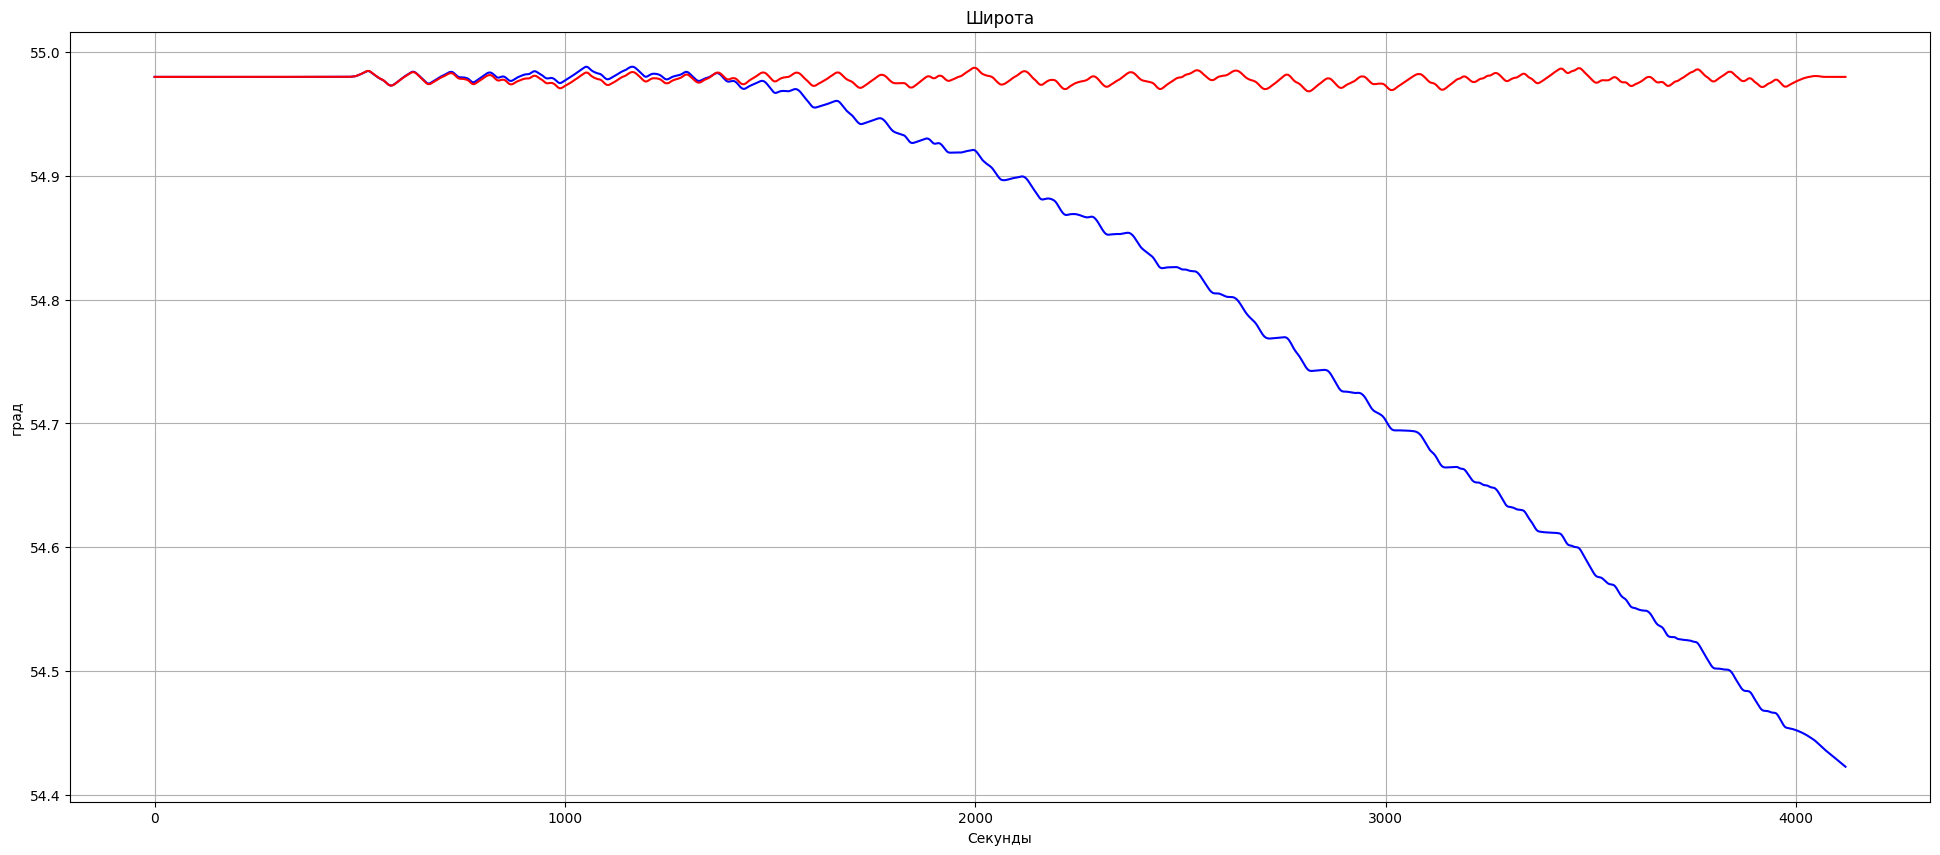

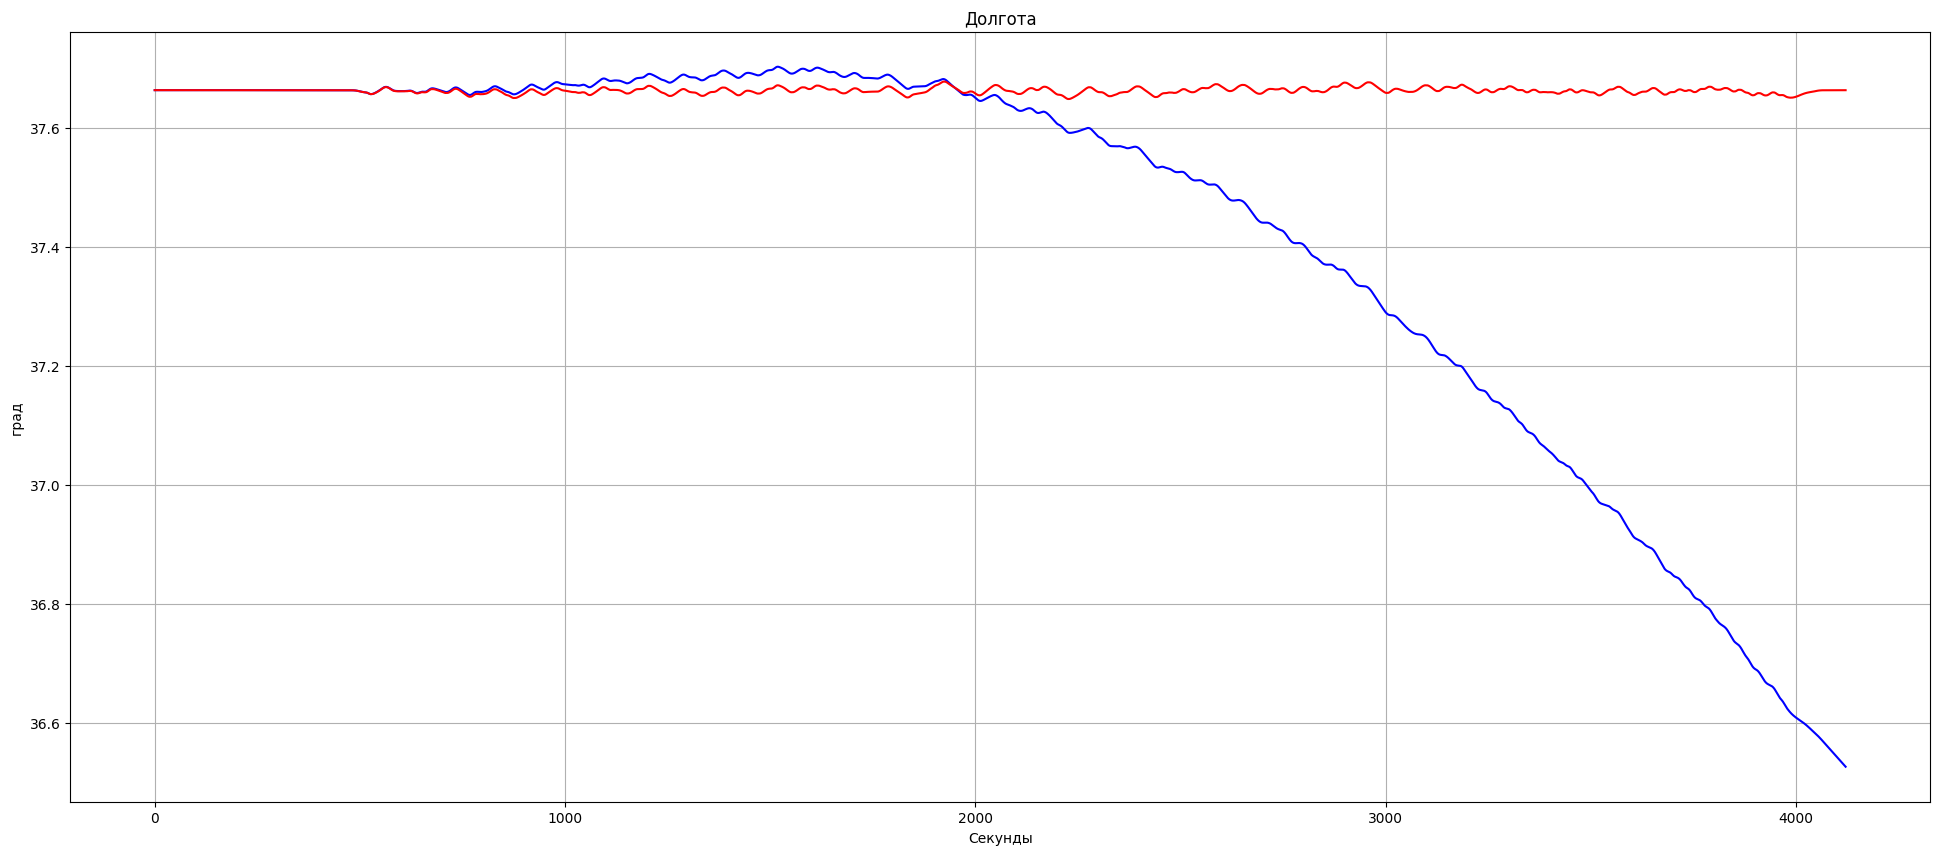

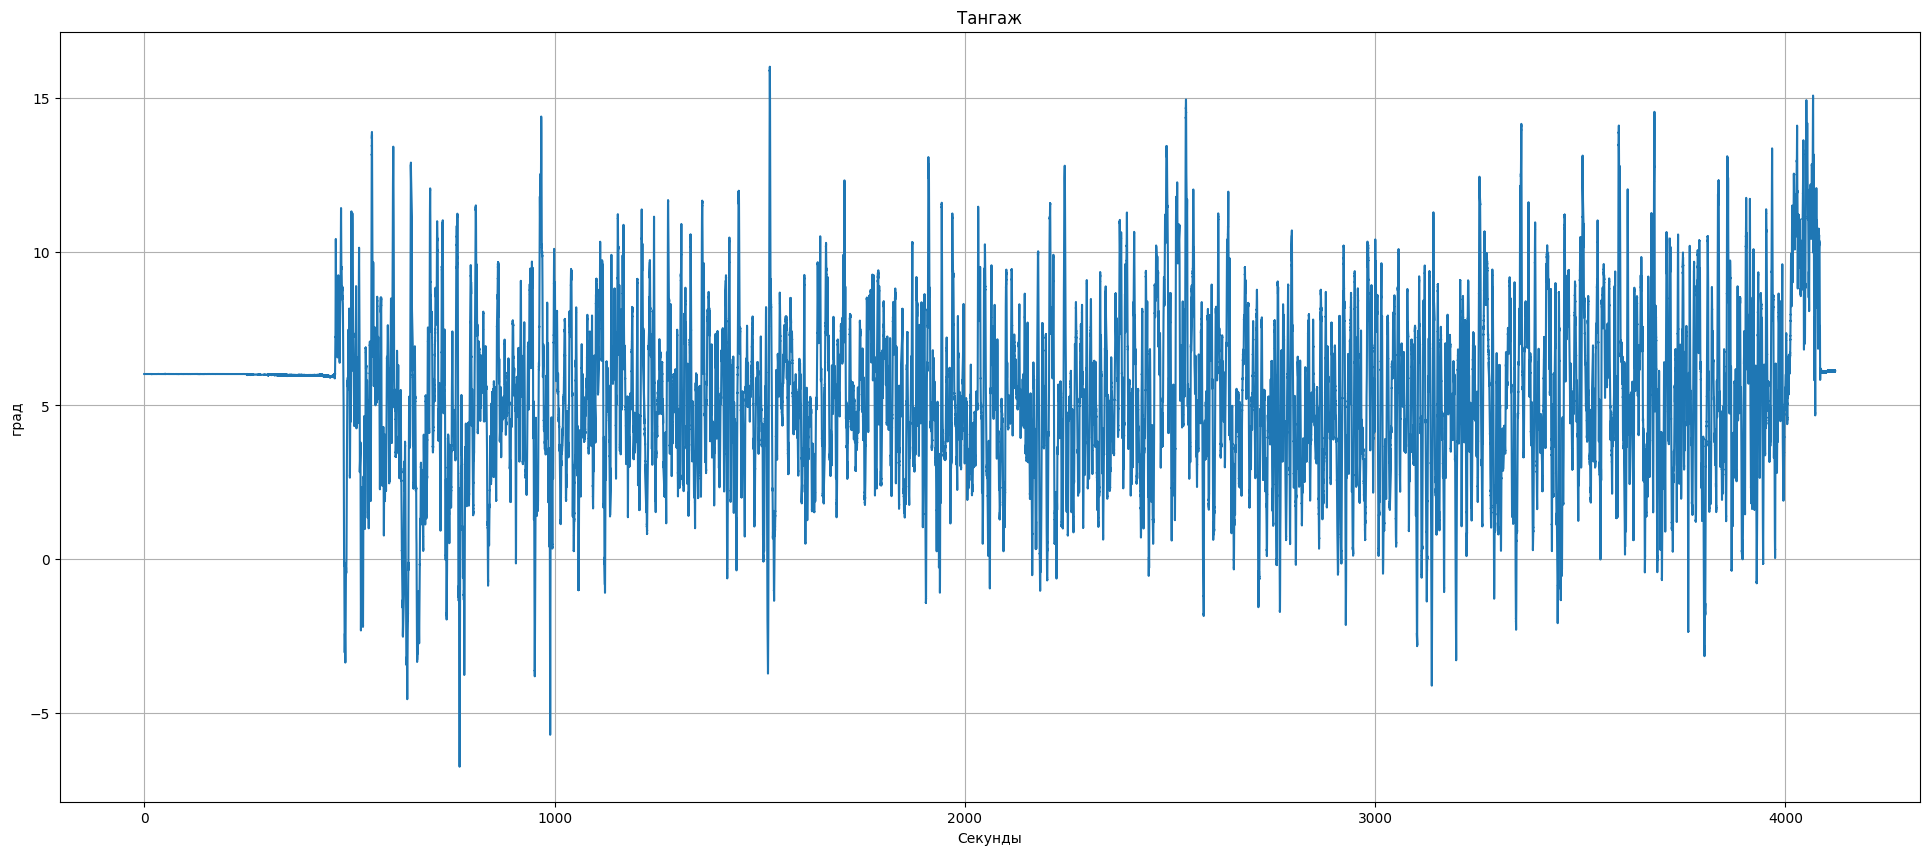

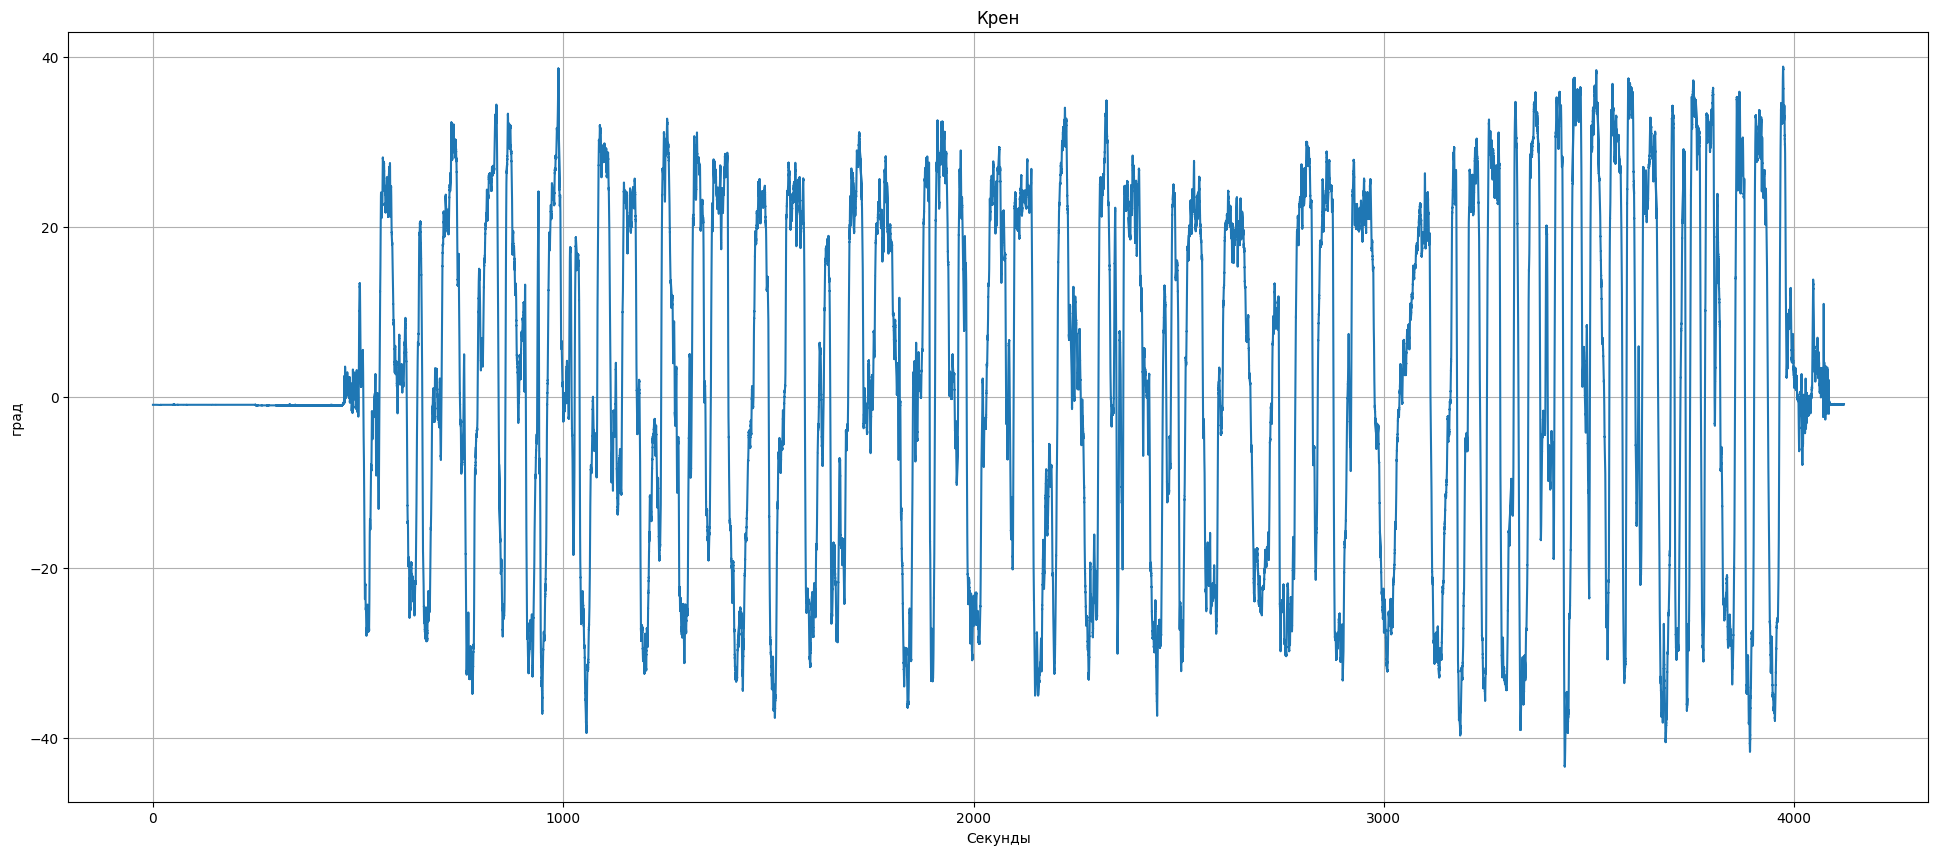

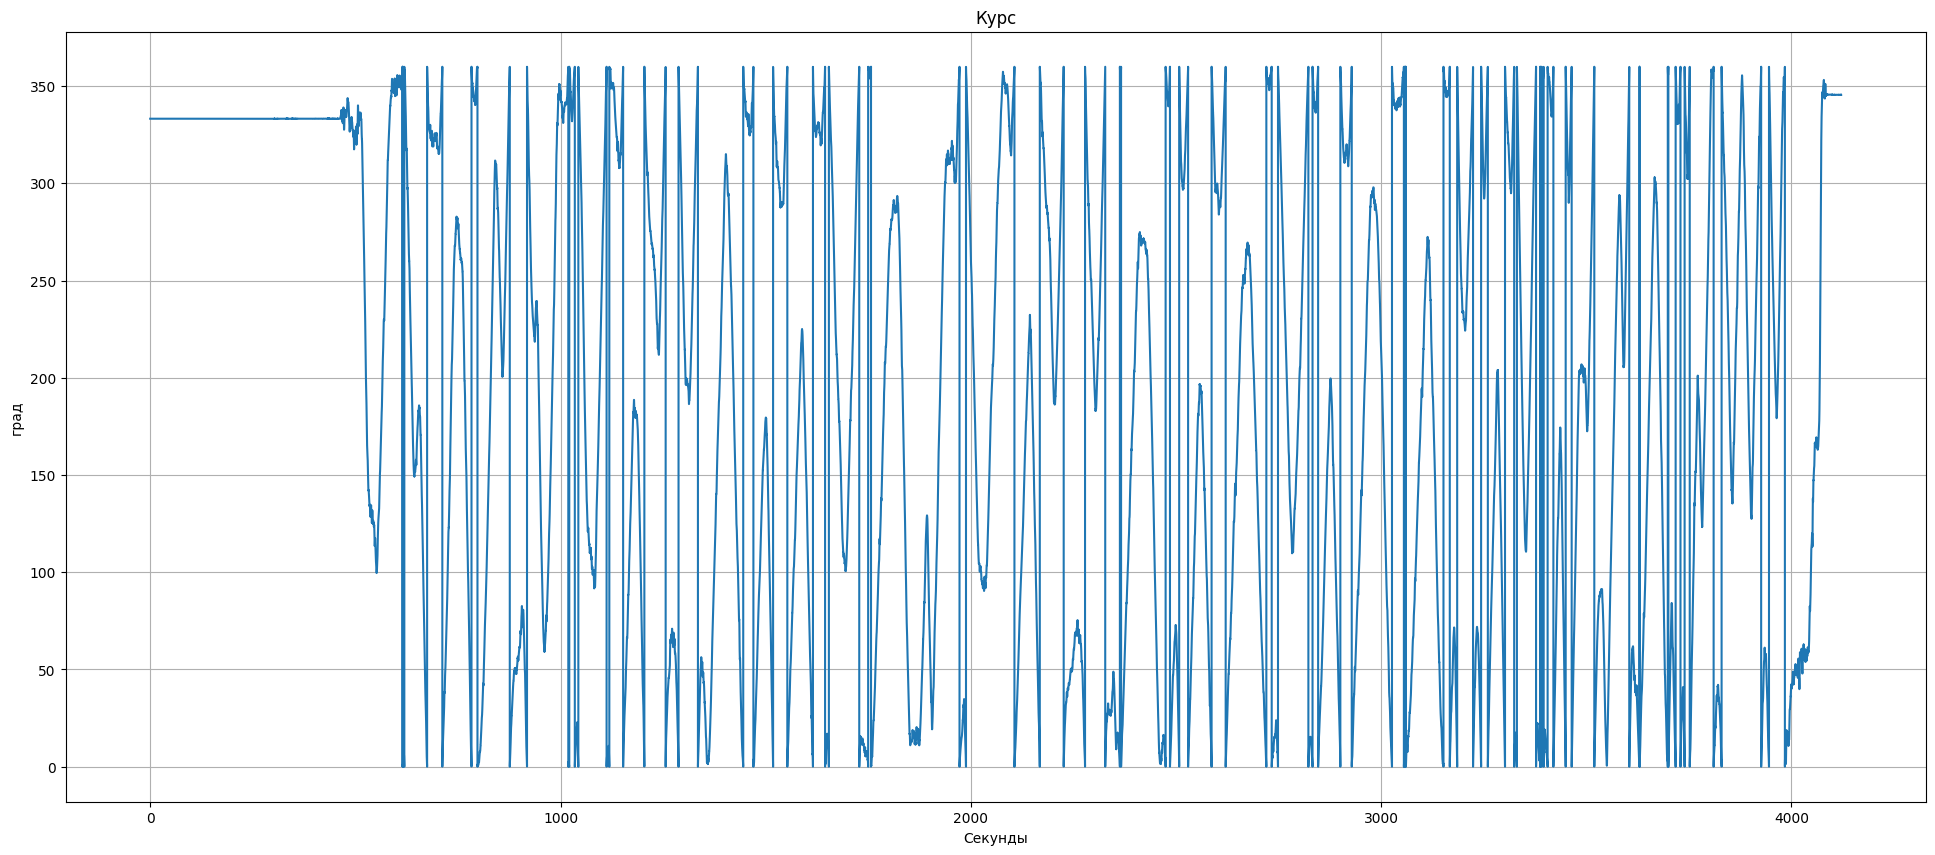

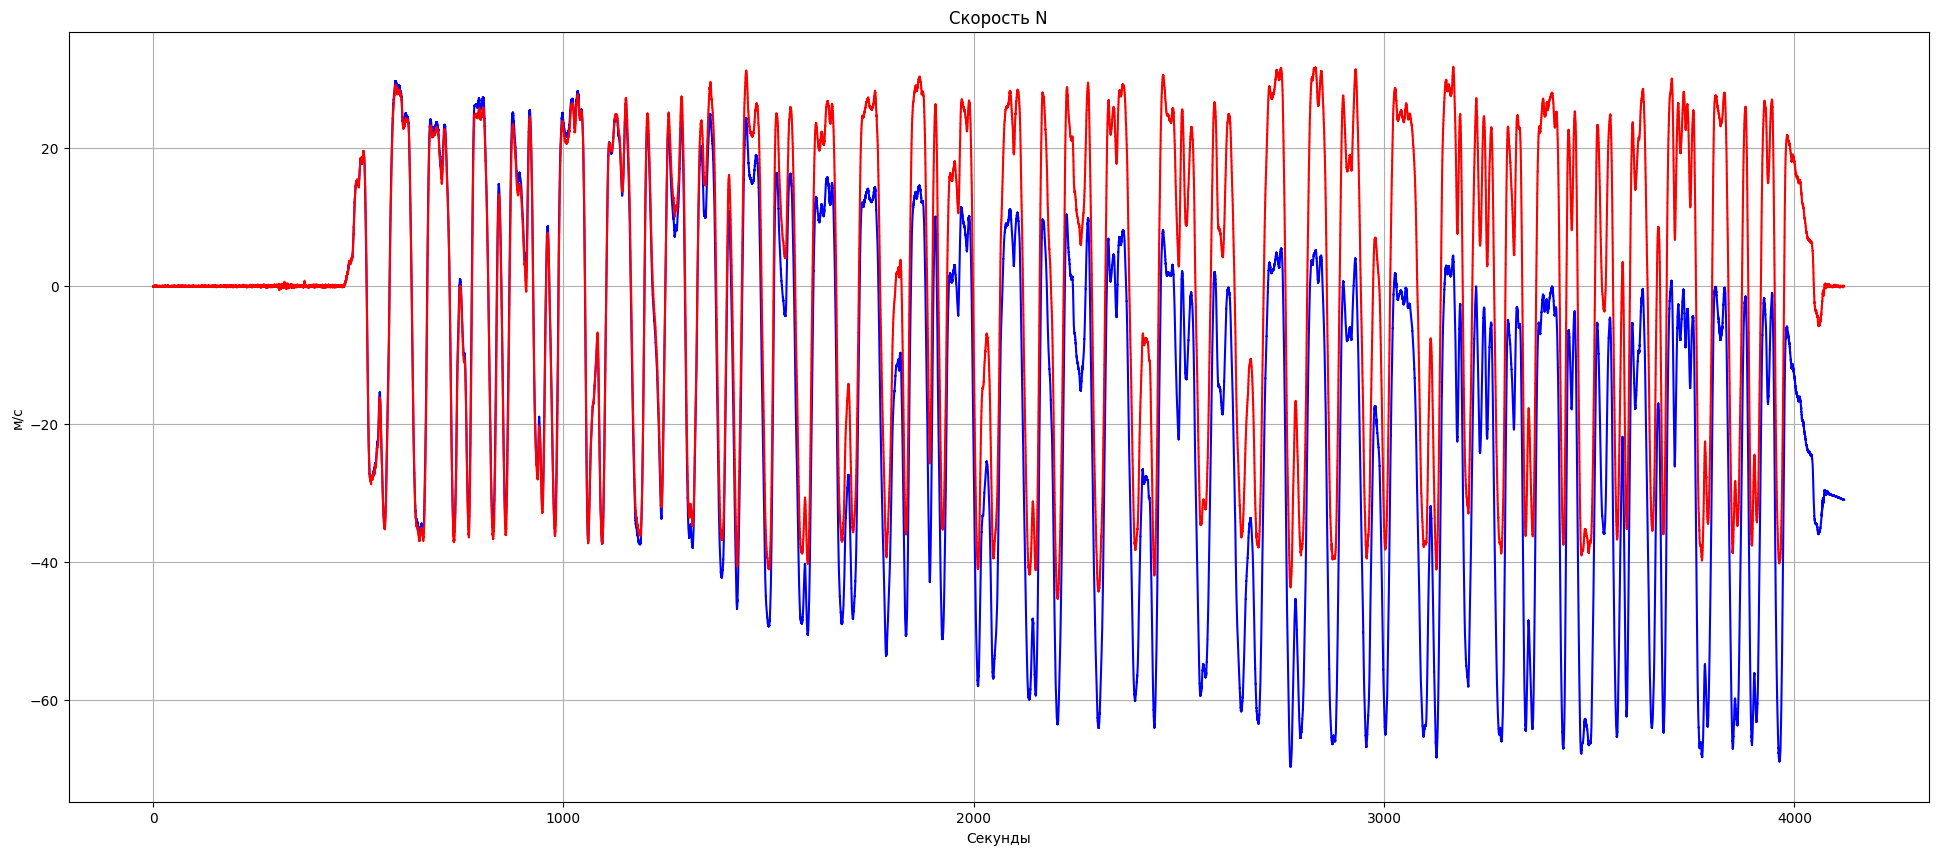

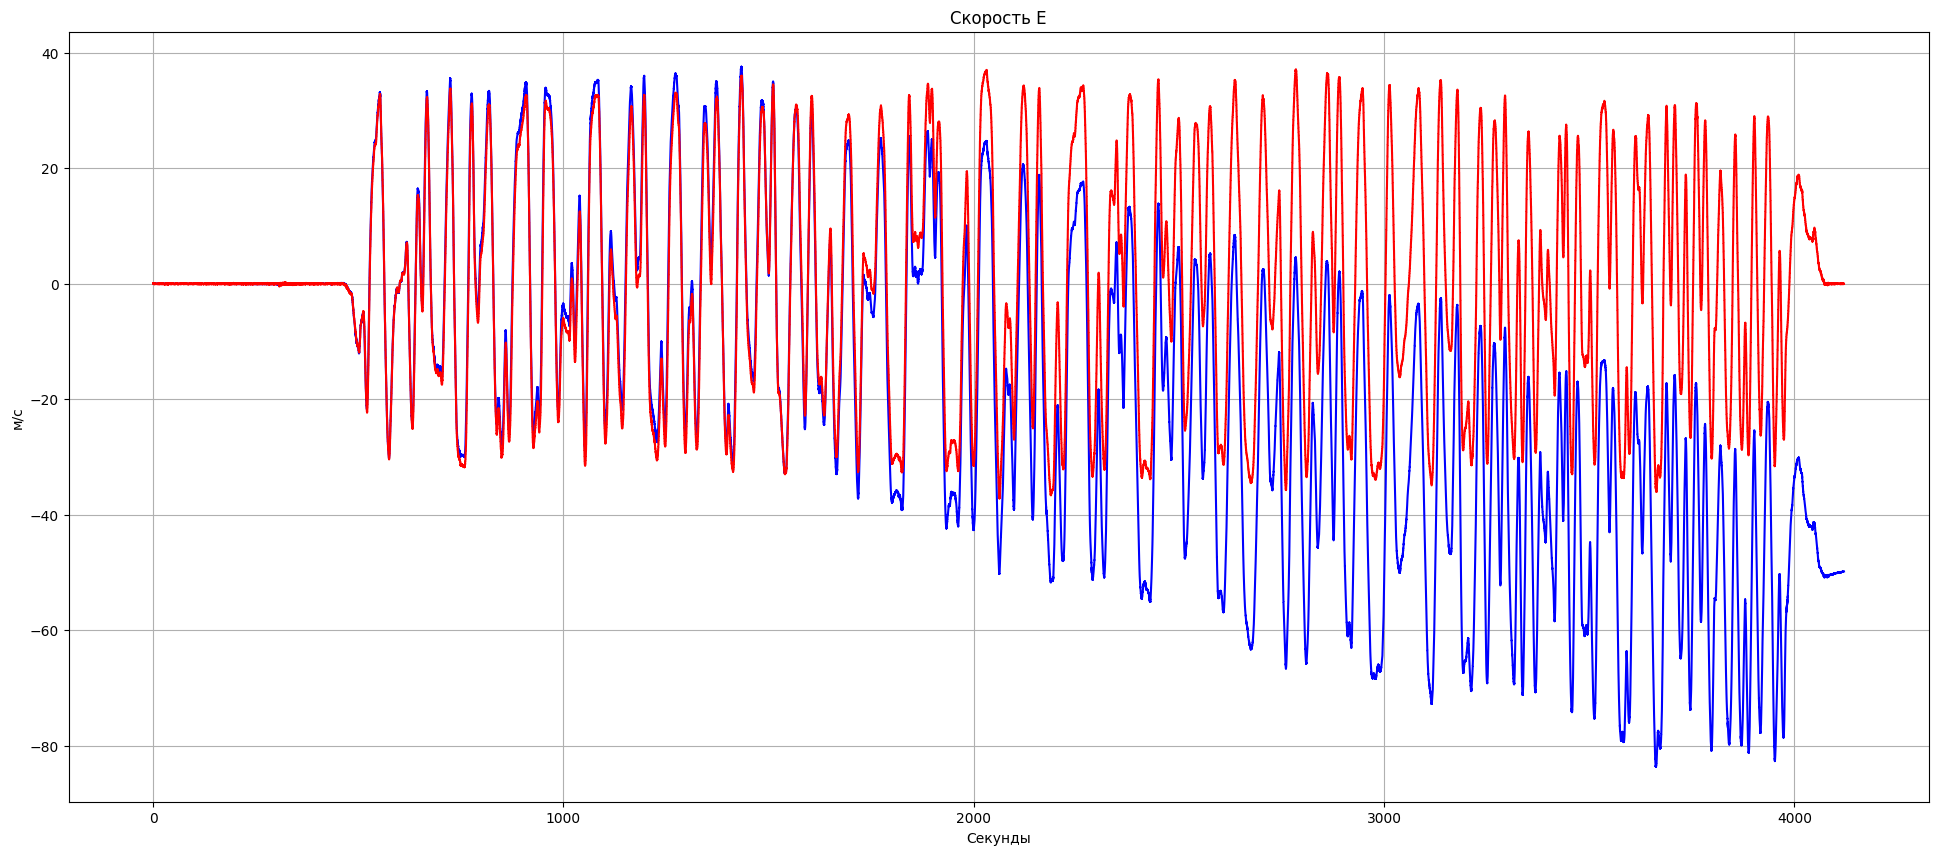

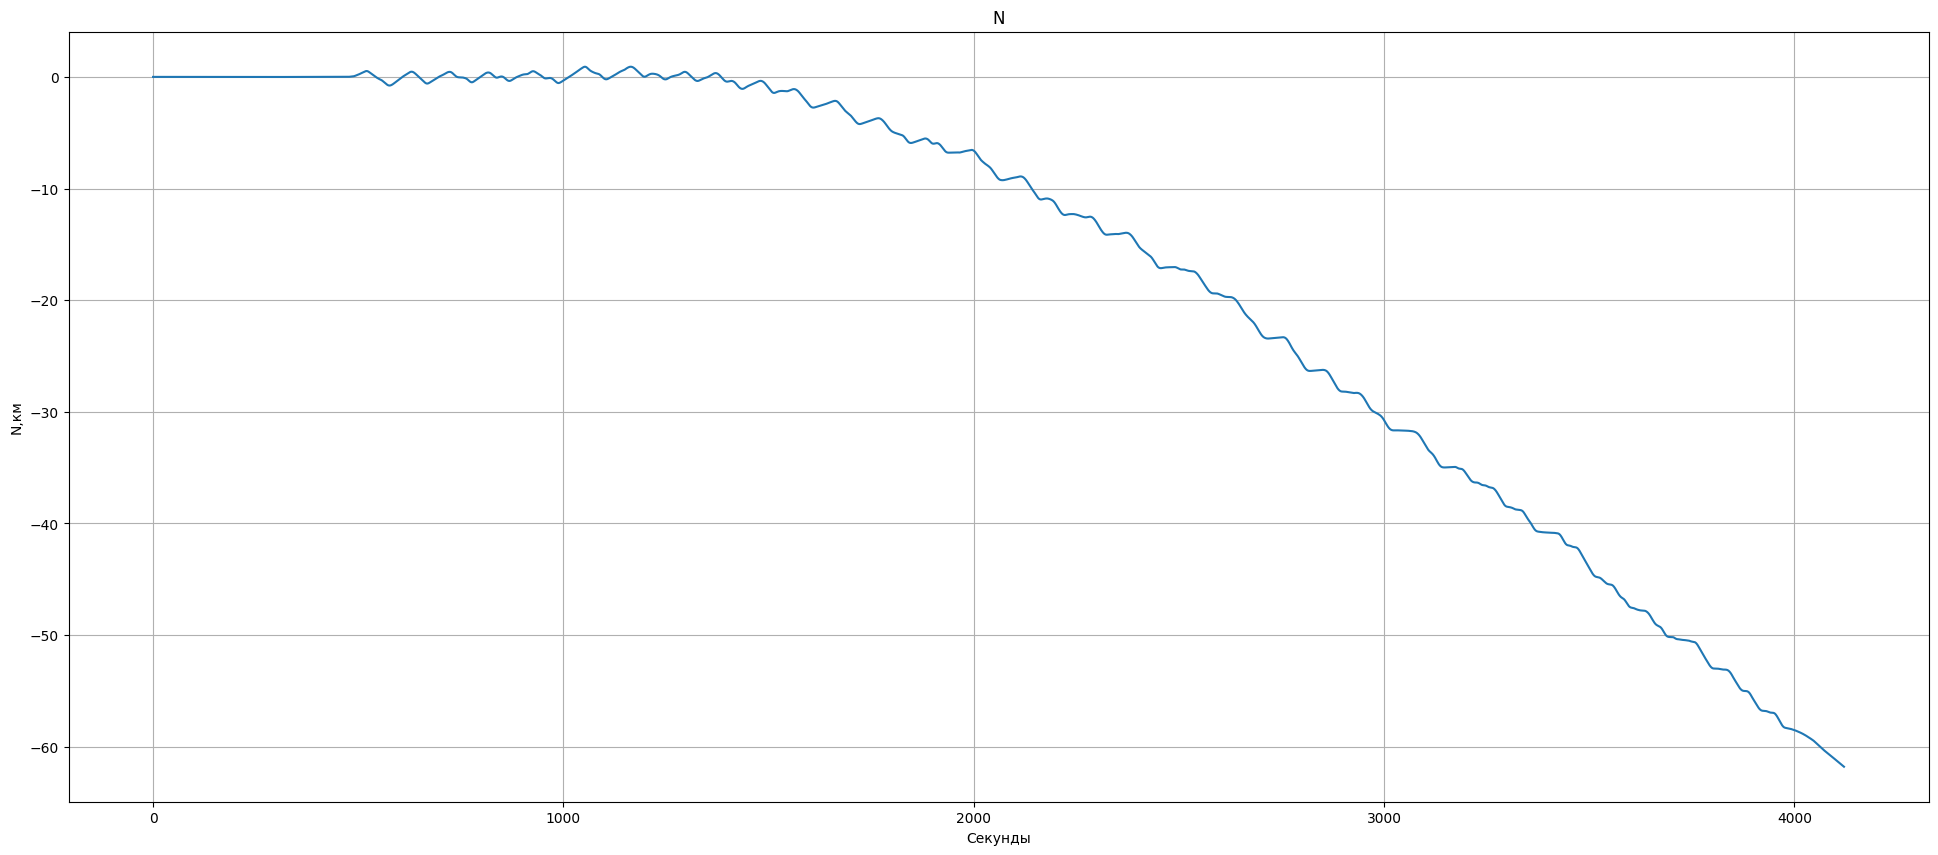

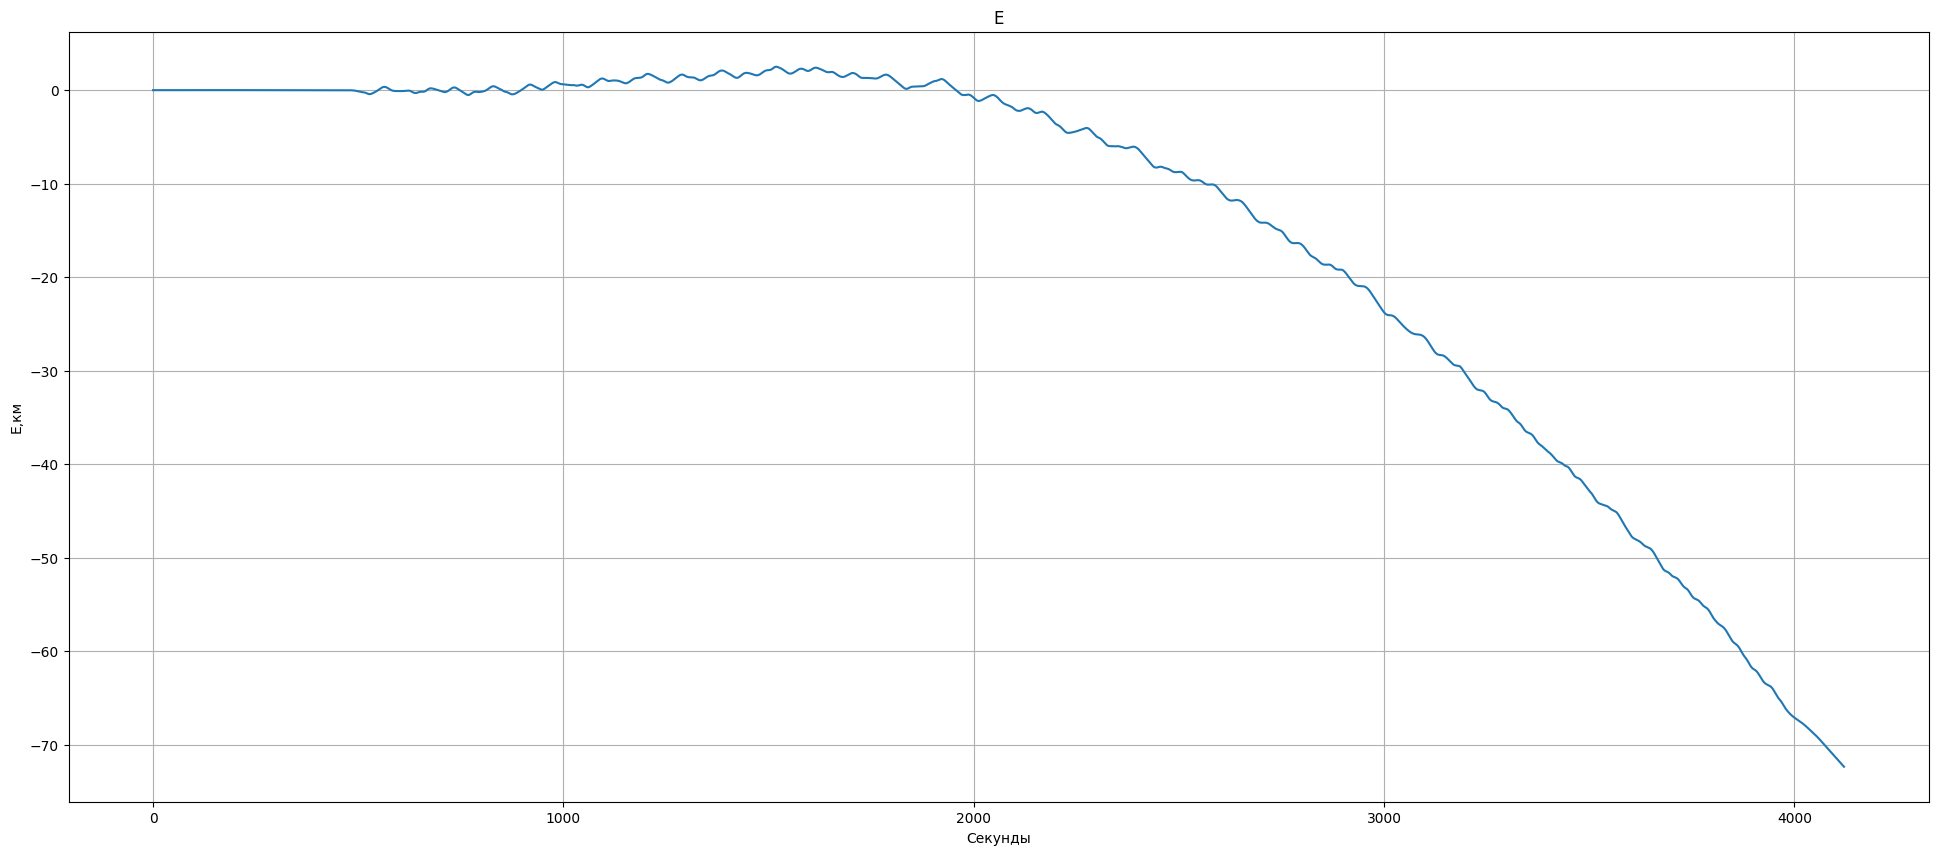

In [60]:
plt.figure(1)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_Lat,'b')
plt.plot(t,out_queue_GPS_Lat,'r')
plt.title("Широта")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(2)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_Lon,'b')
plt.plot(t,out_queue_GPS_Lon,'r')
plt.title("Долгота")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(3)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_pitch)
plt.title("Тангаж")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(4)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_roll)
plt.title("Крен")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(5)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_heading)
plt.title("Курс")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(6)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_W_N,'b')
plt.plot(t,out_queue_GPS_W_N,'r')
plt.title("Скорость N")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

plt.figure(7)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_W_E,'b')
plt.plot(t,out_queue_GPS_W_E,'r')
plt.title("Скорость E")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()


R = 6356.863 # км
out_queue_x = (out_queue_Lat * ((np.pi / 180) * R)) - (out_queue_Lat[0] * ((np.pi / 180) * R))
out_queue_y = (out_queue_Lon * (np.pi / 180) * (R * np.cos(Lat))) - (out_queue_Lon[0] * np.pi / 180 * (R * np.cos(Lat)))
plt.figure(9)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_x[:N])
plt.title("N")
plt.xlabel('Cекунды')
plt.ylabel('N,км')
plt.grid(True)
plt.show()

plt.figure(10)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_y[:N])
plt.title("E")
plt.xlabel('Cекунды')
plt.ylabel('E,км')
plt.grid(True)
plt.show()